# Image Inpainting

### Description

We'll first explore a fun application: painting an image. This network is just meant to demonstrate how the simple networks can be scaled to more complicated tasks without much modification.

Let's first get an image that we'll try to teach a neural network to paint.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import tensorflow as tf
plt.style.use('ggplot')

In [2]:
%matplotlib inline

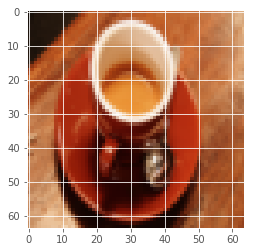

In [3]:
from skimage.data import coffee
from scipy.misc import imresize
img = imresize(coffee(), (64, 64))
plt.imshow(img)
plt.show()

Let's  create a function to create layers of our nueral net

In [4]:
def linear(X, n_input, n_output, activation=None, scope=None):
    with tf.variable_scope(scope or "linear"):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1))
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer())
        h = tf.matmul(X, W) + b
        if activation is not None:
            h = activation(h)
        return h

Teach a network to go from the location on an image frame to a particular color. So given any position in an image, the network will need to learn what color to paint. Despite the seeming complexity of this task, it is remarkably simiple with nueral network. Let's take a look.

In [5]:
# We'll first collect all the positions in the image in our list, xs
xs = []

# And the corresponding colors for each of these positions
ys = []

# Now loop over the image
for row_i in range(img.shape[0]):
    for col_i in range(img.shape[1]):
        # And store the inputs
        xs.append([row_i, col_i])
        # And outputs that the network needs to learn to predict
        ys.append(img[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs)) / np.std(xs)

# and print the shapes
xs.shape, ys.shape

((4096, 2), (4096, 3))

What we're going to do is use regression to predict the value of a pixel given its (row, col) position. So the input to our network is X = (row, col) value. And the output of the network is Y = (r, g, b).

We can get our original image back by reshaping the colors back into the original image shape:

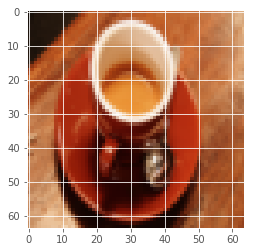

In [6]:
plt.imshow(ys.reshape(img.shape))

we were using regression to input to our network X = x, and output Y = y. The only thing that is changing here is the number of values in our input and output, and what they represent to us. But Tensorflow can handle any number of values we give it, so this is actually a pretty simple modification to the network definition.

In [7]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 3], name='Y')

### Building the Network

For our model, we'll make our deep neural network! Instead of having a single fully connected layer, we'll have many layers. We'll make use of a for loop to simplify the creation of the network. The network will look like:

In [8]:
n_neurons = [2, 64, 64, 64, 64, 64, 64, 3]

current_input = X
for layer_i in range(1, len(n_neurons)):
    current_input = linear(
        X=current_input,
        n_input=n_neurons[layer_i - 1],
        n_output=n_neurons[layer_i],
        activation=tf.nn.relu if (layer_i+1) < len(n_neurons) else None,
        scope='layer_' + str(layer_i))
Y_pred = current_input

### Training

In order to better measure the error, we'll sum the error across all 3(RGB) values. There are many ways we could have approached this which we'll get into in later sessions.

In [10]:
# this function will measure the absolute distance, also known as the l1-norm
def distance(p1, p2):
    return tf.abs(p1 - p2)

In [11]:
cost = tf.reduce_mean(
    tf.reduce_sum(distance(Y_pred, Y), 1))

We're going to use a different type of optimizer called AdamOptimizer which in general will work better than the original GradientDescentOptimizer. It's pretty similar, except it has some tricks to help with gradient descent

In [12]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Create a session to iterate over chunks of our training data. Every 20 iterations, we're going to draw the predicted image by evaluating the predicted image tensor, Y_pred, and giving it every location in the image to predict, the xs array. This will return us the predicted color values for those locations.

0 115.466
1 106.62
2 104.893
3 101.371
4 98.1727
5 95.4018
6 90.4196
7 87.7415
8 83.8618
9 81.9288
10 82.1231
11 79.5153
12 79.1382
13 79.7408
14 78.8578
15 80.531
16 77.808
17 77.5774
18 78.4405
19 78.4831


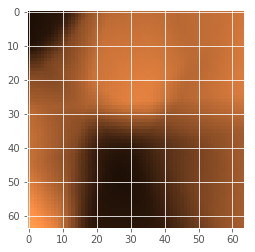

20 76.9025
21 77.4237
22 78.4614
23 76.757
24 76.0701
25 78.5604
26 76.1667
27 76.0512
28 75.2251
29 75.122
30 75.0858
31 74.5694
32 75.4103
33 75.7019
34 75.9648
35 74.0632
36 72.9527
37 71.8802
38 70.3013
39 69.1337


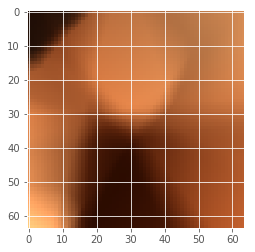

40 70.5465
41 67.1836
42 65.8954
43 67.6288
44 63.6506
45 62.3058
46 61.6227
47 63.9753
48 61.4598
49 61.9596
50 60.57
51 60.7645
52 59.9021
53 59.0021
54 59.0513
55 60.3103
56 58.4447
57 56.5221
58 56.9379
59 57.2562


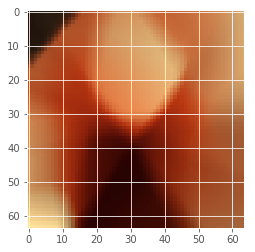

60 57.5513
61 56.2102
62 57.3023
63 55.075
64 56.5145
65 55.7207
66 55.4052
67 57.1958
68 56.347
69 54.9918
70 54.3739
71 54.933
72 56.4839
73 54.4778
74 53.7462
75 53.1509
76 54.4839
77 53.8423
78 53.862
79 53.2368


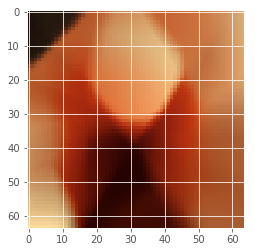

80 53.755
81 54.1706
82 53.3868
83 52.48
84 52.3411
85 52.829
86 52.2938
87 53.8913
88 52.8076
89 52.7689
90 51.546
91 50.8605
92 50.2019
93 51.1273
94 50.0506
95 49.6179
96 48.7311
97 48.9389
98 48.179
99 48.1681


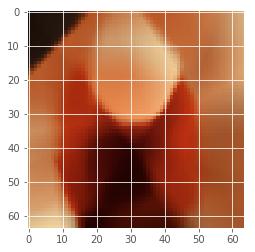

100 47.6813
101 47.3372
102 46.4562
103 50.1915
104 45.4832
105 52.3755
106 45.9758
107 45.2553
108 45.9049
109 45.0132
110 46.5999
111 43.1833
112 45.3309
113 44.4394
114 46.3006
115 43.9961
116 45.8399
117 46.797
118 42.8522
119 44.1146


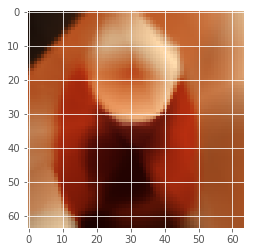

120 42.6116
121 44.2963
122 44.7412
123 41.3094
124 47.3089
125 41.2162
126 45.6951
127 40.9315
128 43.306
129 44.3228
130 41.2973
131 43.1177
132 42.4938
133 39.54
134 41.3148
135 40.2155
136 39.4756
137 39.3017
138 40.5366
139 40.4104


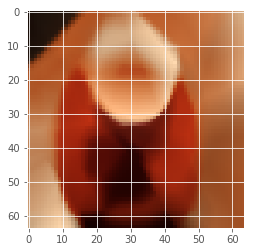

140 39.5225
141 38.5587
142 40.8621
143 39.6521
144 41.5403
145 39.822
146 40.8601
147 39.3429
148 39.0688
149 37.5453
150 38.4664
151 40.5661
152 37.4947
153 36.8888
154 38.5194
155 36.6435
156 37.0955
157 38.2567
158 38.3418
159 40.7875


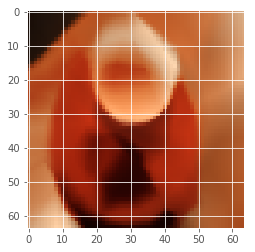

160 39.1836
161 35.9611
162 42.1827
163 36.0841
164 37.2761
165 35.9972
166 34.2954
167 35.1348
168 34.3822
169 36.7157
170 36.0673
171 36.8013
172 34.613
173 34.5921
174 34.9881
175 34.6304
176 35.3585
177 35.6385
178 34.3998
179 33.9269


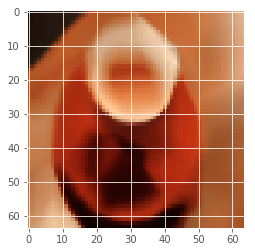

180 33.7671
181 34.1727
182 34.2426
183 32.5939
184 39.9514
185 32.8052
186 36.7112
187 32.6773
188 32.3306
189 34.7112
190 34.2734
191 32.5416
192 32.9115
193 33.5589
194 36.2701
195 32.5256
196 35.0072
197 33.4712
198 33.5248
199 32.2859


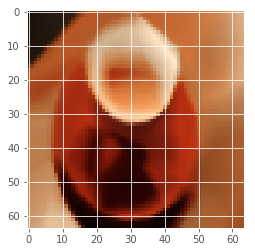

200 31.1189
201 31.4207
202 33.5254
203 33.116
204 32.0528
205 32.8442
206 36.1326
207 33.7554
208 32.2899
209 32.274
210 31.9129
211 35.6966
212 31.0984
213 29.5001
214 30.1866
215 31.4549
216 35.1328
217 32.1058
218 32.4247
219 30.0311


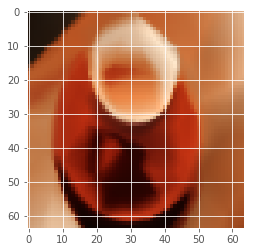

220 29.5557
221 30.8394
222 30.2956
223 29.1665
224 33.745
225 31.4238
226 32.6059
227 29.9623
228 28.8621
229 31.9565
230 28.8791
231 29.9704
232 30.4608
233 29.5696
234 33.2615
235 28.4345
236 31.4874
237 29.6058
238 30.9603
239 32.9133


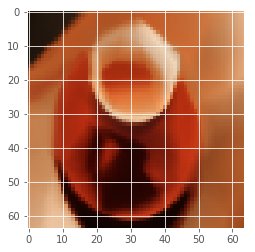

240 31.9854
241 30.4364
242 30.6514
243 28.6282
244 28.3954
245 29.5799
246 31.2277
247 27.8847
248 29.7116
249 30.5709
250 32.1841
251 27.1972
252 29.0465
253 27.7368
254 33.8169
255 28.3804
256 30.1695
257 28.6362
258 28.353
259 28.8796


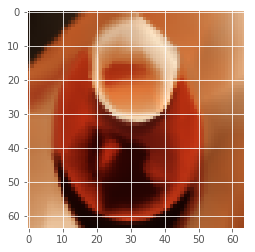

260 28.2808
261 26.8214
262 26.6751
263 29.0388
264 28.8105
265 27.8258
266 26.8039
267 33.2919
268 26.5014
269 33.4786
270 27.1505
271 28.8818
272 28.117
273 27.8984
274 29.4119
275 26.7258
276 29.4565
277 29.1061
278 28.0427
279 29.6361


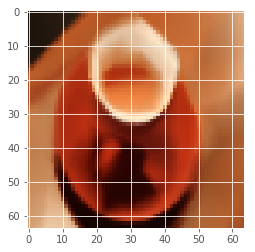

280 28.5604
281 27.2048
282 28.5224
283 30.0922
284 30.4999
285 29.5021
286 25.709
287 29.2209
288 28.0891
289 27.2835
290 31.3684
291 28.7735
292 25.2744
293 26.5468
294 25.8995
295 28.9096
296 26.1428
297 29.9381
298 29.1402
299 27.0761


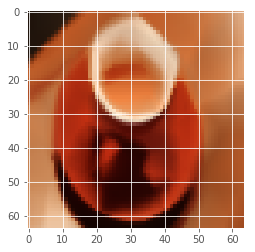

300 27.3713
301 25.6683
302 26.2756
303 26.6129
304 25.5475
305 27.0788
306 26.0351
307 26.9384
308 26.3235
309 26.1428
310 27.6249
311 26.7253
312 25.5828
313 27.3825
314 28.1386
315 28.6993
316 24.9265
317 26.3796
318 26.8099
319 27.164


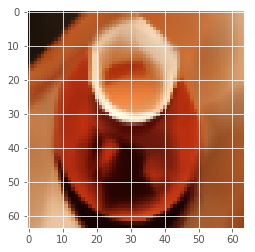

320 26.0386
321 26.7835
322 25.8204
323 26.4495
324 24.5088
325 25.5248
326 27.2851
327 27.4058
328 28.0658
329 25.8855
330 29.5668
331 25.9026
332 25.3349
333 26.6935
334 25.9058
335 27.7775
336 24.26
337 26.1035
338 24.95
339 28.6152


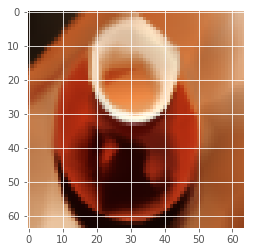

340 24.9287
341 25.9258
342 25.2631
343 25.7693
344 26.9471
345 24.9922
346 26.3762
347 24.4851
348 27.4317
349 25.3835
350 23.8765
351 24.7718
352 23.9641
353 25.4367
354 29.0194
355 23.5553
356 27.2084
357 25.0222
358 24.2466
359 25.8038


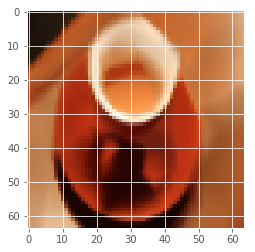

360 24.9451
361 23.8531
362 25.2784
363 24.6157
364 23.9128
365 28.1585
366 22.7625
367 25.937
368 25.345
369 24.6979
370 24.9055
371 24.1144
372 26.0705
373 25.7068
374 24.7992
375 23.1989
376 23.7583
377 22.3622
378 25.3779
379 24.0842


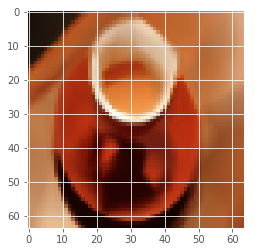

380 24.5643
381 23.3735
382 24.9594
383 23.7518
384 22.9775
385 23.4396
386 24.5473
387 25.6064
388 24.117
389 27.6923
390 22.5663
391 22.9823
392 23.9593
393 22.3378
394 24.7952
395 23.0242
396 22.2548
397 25.4585
398 23.476
399 22.5614


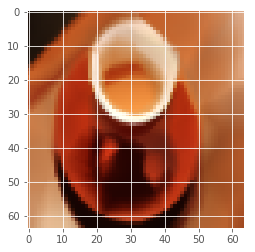

400 23.336
401 24.9456
402 24.1925
403 24.3347
404 22.8287
405 22.4876
406 25.2314
407 24.3981
408 25.3733
409 22.3829
410 24.2937
411 22.2589
412 22.7665
413 23.9458
414 23.7897
415 23.9986
416 23.7111
417 21.8172
418 22.4679
419 21.8009


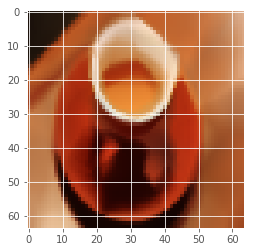

420 23.3315
421 21.3864
422 23.0791
423 25.4534
424 23.0635
425 24.0143
426 21.9935
427 23.0873
428 22.4558
429 23.5323
430 22.4625
431 22.0277
432 21.1979
433 22.1411
434 22.7963
435 23.97
436 23.6523
437 22.576
438 22.0168
439 21.8069


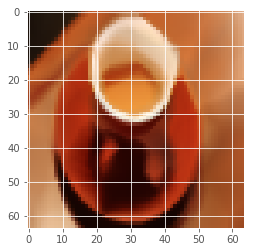

440 21.2742
441 23.8023
442 24.5748
443 23.2175
444 21.2401
445 21.6874
446 24.9557
447 22.8407
448 23.186
449 22.0711
450 20.3424
451 21.8698
452 22.9611
453 21.5362
454 22.7363
455 22.217
456 21.2697
457 20.4978
458 20.8373
459 23.7856


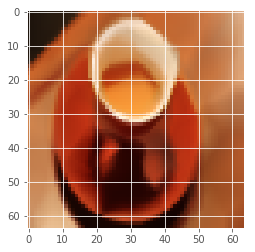

460 21.1889
461 21.5273
462 21.8046
463 22.5095
464 20.4401
465 22.6321
466 22.2602
467 24.189
468 21.6272
469 20.5409
470 19.7695
471 21.1672
472 20.3783
473 21.3672
474 21.8008
475 21.0404
476 20.4252
477 23.7433
478 22.0201
479 23.0253


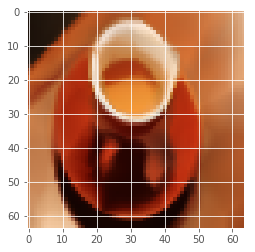

480 23.3843
481 23.253
482 24.0773
483 22.9462
484 20.6041
485 21.12
486 22.0933
487 20.145
488 19.9817
489 23.6858
490 21.9379
491 22.6399
492 20.1049
493 20.7615
494 20.247
495 23.8349
496 23.8142
497 20.9106
498 22.9614
499 21.8106


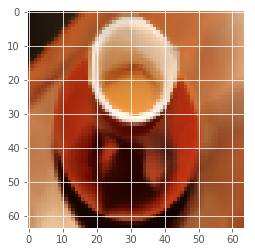

In [13]:
n_iterations = 500
batch_size = 50
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(tf.global_variables_initializer())

    # We now run a loop over epochs
    prev_training_cost = 0.0
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})

        training_cost = sess.run(cost, feed_dict={X: xs, Y: ys})
        print(it_i, training_cost)

        if (it_i + 1) % 20 == 0:
            ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
            fig, ax = plt.subplots(1, 1)
            img = np.clip(ys_pred.reshape(img.shape), 0, 255).astype(np.uint8)
            plt.imshow(img)
            plt.show()